<a href="https://colab.research.google.com/github/Manika7777/Image-Recognition-MNIST-CNN/blob/main/image_recognition_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU available: []


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train: (60000, 28, 28) y_train: (60000,)
x_test: (10000, 28, 28) y_test: (10000,)


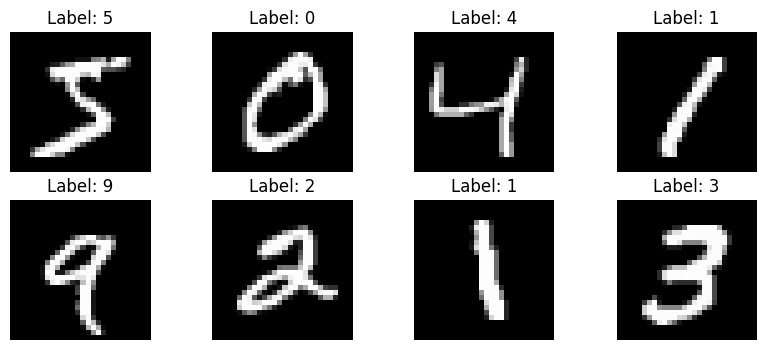

In [3]:
plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()


In [4]:
# reshape to (samples, 28, 28, 1) and scale to [0,1]
x_train = x_train.reshape(-1,28,28,1).astype('float32') / 255.0
x_test  = x_test.reshape(-1,28,28,1).astype('float32') / 255.0

# one-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat  = to_categorical(y_test, num_classes=10)

print(x_train.shape, y_train_cat.shape)


(60000, 28, 28, 1) (60000, 10)


In [5]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(10, activation='softmax')
    ])
    return model

model = build_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,954 (949.04 KB)

 Trainable params: 242,250 (946.29 KB)

 Non-trainable params: 704 (2.75 KB)

In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [7]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(x_train)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    ModelCheckpoint('best_mnist_model.h5', monitor='val_accuracy', save_best_only=True)
]


In [8]:
batch_size = 128
epochs = 15

history = model.fit(
    datagen.flow(x_train, y_train_cat, batch_size=batch_size),
    steps_per_epoch = x_train.shape[0] // batch_size,
    epochs = epochs,
    validation_data = (x_test, y_test_cat),
    callbacks = callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8389 - loss: 0.5171

468/468 ━━━━━━━━━━━━━━━━━━━━ 95s 191ms/step - accuracy: 0.8391 - loss: 0.5165 - val_accuracy: 0.9252 - val_loss: 0.2502 - learning_rate: 0.0010
Epoch 2/15
  1/468 ━━━━━━━━━━━━━━━━━━━━ 1:04 138ms/step - accuracy: 0.9609 - loss: 0.0828

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9609 - loss: 0.0828 - val_accuracy: 0.9282 - val_loss: 0.2408 - learning_rate: 0.0010
Epoch 3/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9698 - loss: 0.0993

468/468 ━━━━━━━━━━━━━━━━━━━━ 88s 189ms/step - accuracy: 0.9698 - loss: 0.0993 - val_accuracy: 0.9847 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 4/15
  1/468 ━━━━━━━━━━━━━━━━━━━━ 1:04 137ms/step - accuracy: 0.9609 - loss: 0.0662

468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9609 - loss: 0.0662 - val_accuracy: 0.9849 - val_loss: 0.0482 - learning_rate: 0.0010
Epoch 5/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9779 - loss: 0.0739

468/468 ━━━━━━━━━━━━━━━━━━━━ 139s 190ms/step - accuracy: 0.9779 - loss: 0.0739 - val_accuracy: 0.9886 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 6/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 1.0000 - loss: 0.0257 - val_accuracy: 0.9886 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 7/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9799 - loss: 0.0626

468/468 ━━━━━━━━━━━━━━━━━━━━ 90s 192ms/step - accuracy: 0.9799 - loss: 0.0626 - val_accuracy: 0.9898 - val_loss: 0.0310 - learning_rate: 0.0010
Epoch 8/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9922 - loss: 0.0263 - val_accuracy: 0.9896 - val_loss: 0.0319 - learning_rate: 0.0010
Epoch 9/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9837 - loss: 0.0543

468/468 ━━━━━━━━━━━━━━━━━━━━ 137s 192ms/step - accuracy: 0.9837 - loss: 0.0543 - val_accuracy: 0.9919 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 10/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 1.0000 - loss: 0.0136 - val_accuracy: 0.9916 - val_loss: 0.0247 - learning_rate: 0.0010
Epoch 11/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 140s 195ms/step - accuracy: 0.9840 - loss: 0.0493 - val_accuracy: 0.9895 - val_loss: 0.0302 - learning_rate: 0.0010
Epoch 12/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 1.0000 - loss: 0.0202 - val_accuracy: 0.9898 - val_loss: 0.0296 - learning_rate: 5.0000e-04
Epoch 13/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9867 - loss: 0.0430

468/468 ━━━━━━━━━━━━━━━━━━━━ 135s 191ms/step - accuracy: 0.9868 - loss: 0.0430 - val_accuracy: 0.9934 - val_loss: 0.0197 - learning_rate: 5.0000e-04
Epoch 14/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9609 - loss: 0.1097 - val_accuracy: 0.9931 - val_loss: 0.0198 - learning_rate: 5.0000e-04
Epoch 15/15
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9882 - loss: 0.0373

468/468 ━━━━━━━━━━━━━━━━━━━━ 89s 189ms/step - accuracy: 0.9882 - loss: 0.0373 - val_accuracy: 0.9948 - val_loss: 0.0157 - learning_rate: 5.0000e-04


In [9]:
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test loss: {test_loss:.4f}   Test accuracy: {test_acc:.4f}")


Test loss: 0.0157   Test accuracy: 0.9948


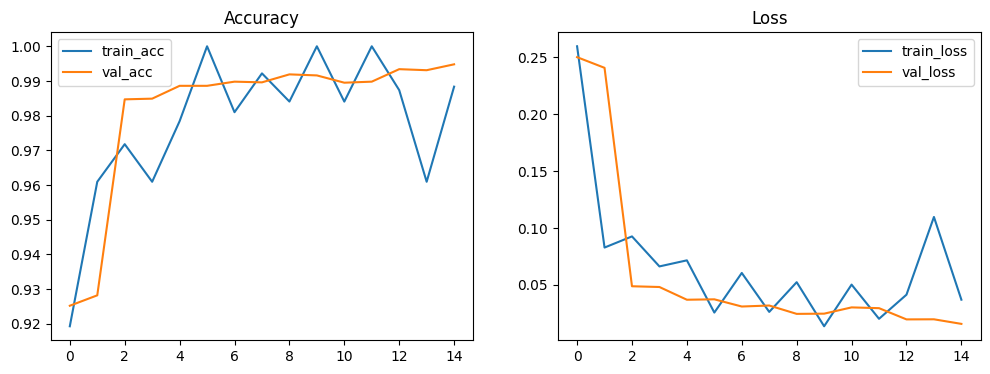

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


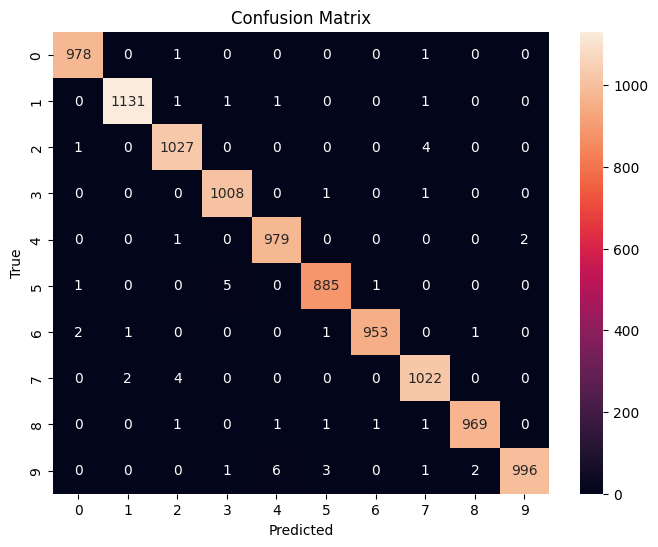

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [11]:
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


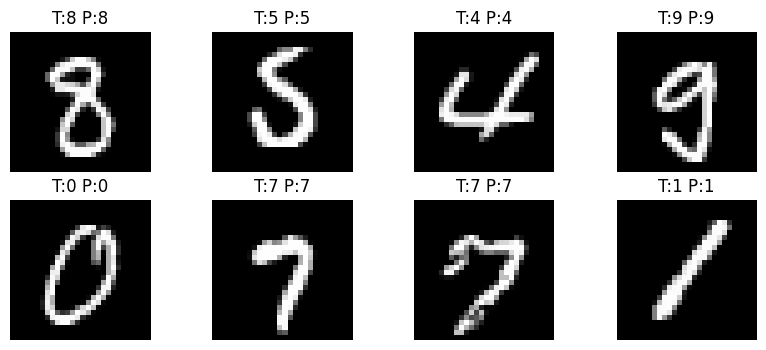

In [22]:
import numpy as np, matplotlib.pyplot as plt
indices = np.random.choice(len(x_test), 8, replace=False)
plt.figure(figsize=(10,4))
for i, idx in enumerate(indices):
    plt.subplot(2,4,i+1)
    plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
    pred = np.argmax(model.predict(x_test[idx:idx+1]))
    plt.title(f"T:{y_test[idx]} P:{pred}")
    plt.axis('off')
plt.show()


In [13]:
# Save local
model.save('/content/best_mnist_model.h5')

# If Drive mounted, save to Drive
# model.save('/content/drive/MyDrive/mnist/best_mnist_model.h5')

# Download to your computer
from google.colab import files
files.download('/content/best_mnist_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Save model in new format
model.save("/content/best_mnist_model.keras")

# Load it later
from tensorflow import keras
loaded_model = keras.models.load_model("/content/best_mnist_model.keras")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 20 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12,4))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()


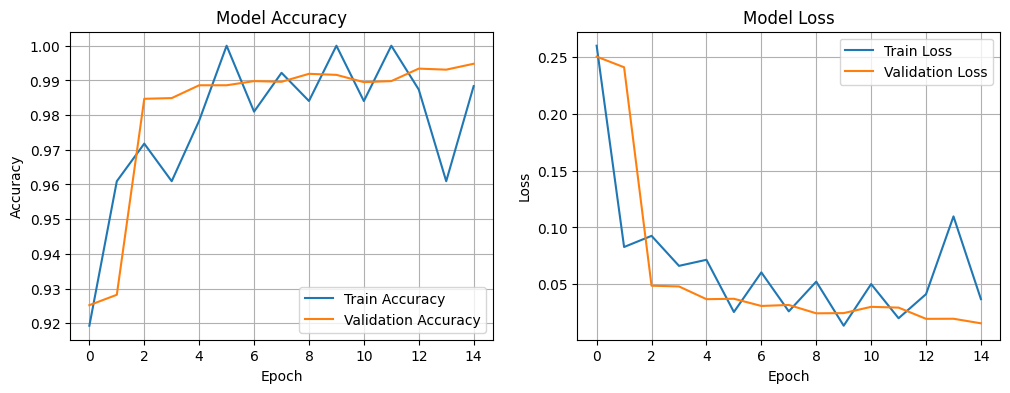

In [16]:
plot_training_history(history)


In [17]:
# Function to display random predictions
def demo_predictions(model, x_test, y_test, num_images=8):
    indices = np.random.choice(len(x_test), num_images, replace=False)
    plt.figure(figsize=(12,4))

    for i, idx in enumerate(indices):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(x_test[idx].reshape(28,28), cmap='gray')
        pred_label = np.argmax(model.predict(x_test[idx:idx+1], verbose=0))
        plt.title(f"True: {y_test[idx]} | Pred: {pred_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


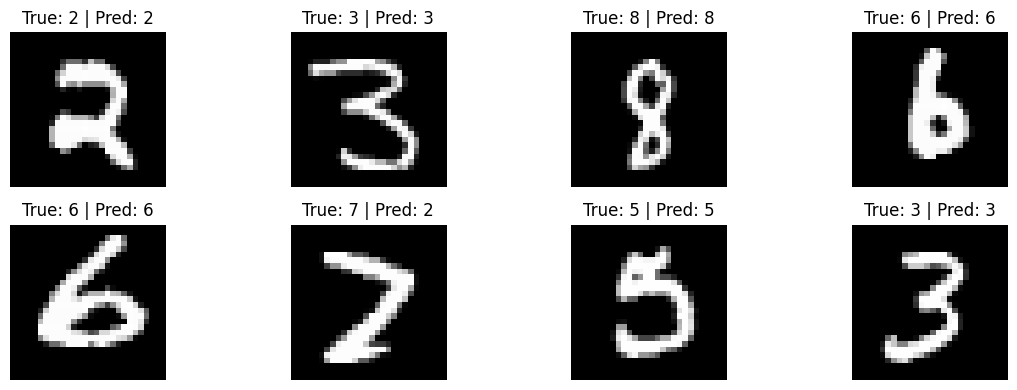

In [18]:
demo_predictions(model, x_test, y_test)


In [19]:
%%writefile requirements.txt
tensorflow==2.15.0
numpy==1.24.3
matplotlib==3.7.1
seaborn==0.12.2
scikit-learn==1.3.0


Writing requirements.txt


In [20]:
from google.colab import files
files.download("requirements.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>